# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

**This data represents 17 marketing campaigns**, which took place between May 2008 and November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Import utilities
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, roc_curve, auc
from sklearn.inspection import permutation_importance

In [6]:
df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep = ';')

In [7]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Fortunately, none of the columns are missing any values (as far as we can see from this). This is in line with what the dataset description from the UCI website suggested.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

The business objective is to identify whether or not customers will subscribe a term deposit with the bank. In order to identify this, we will train several different types of classifiers on the dataset, and evaluate which one performs best at classifying whether a customer will subscribe or not.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

Planned data prep steps:
- remove the 'duration' column (based on suggestion in data description)
- one-hot encode the following: education, job, default, housing, loan, poutcome, marital, contact, month, day_of_week
- standardize the numeric columns: duration, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed
- transform 'y' column into 0/1 binary column for easier scoring?

Notes: Originally I was planning to ordinal-encode some features, particularly education, month and day_of_week, to avoid ballooning the total number of features. But I changed my mind and decided to start with OHE for those features, and I'll only come back to revisit this if I find that the models are too difficult to train with this many features.

In [10]:
# Drop the 'duration' feature
df_clean = df.drop(['duration'], axis=1)

In [11]:
# One-hot encode all the non-ordinal categorical features: education, default, housing, loan, poutcome
for col_name in ['education', 'job', 'default', 'housing', 'loan', 'poutcome', 'marital', 'contact', 'month', 'day_of_week']:
  ohe_enc = OneHotEncoder()
  enc_data = ohe_enc.fit_transform(df[[col_name]]).toarray()
  enc_df = pd.DataFrame(enc_data, columns=ohe_enc.get_feature_names_out([col_name]))
  df_clean = pd.concat([df_clean, enc_df], axis=1)

# Now drop all of the original, non-one-hot-encoded versions of these columns
df_clean = df_clean.drop(['education', 'job', 'default', 'housing', 'loan', 'poutcome', 'marital', 'contact', 'month', 'day_of_week'], axis=1)
df_clean.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
# Standardize the numeric columns: 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'
for col_name in ['campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']:
  scaler = StandardScaler()
  scaled_row = scaler.fit_transform(df[[col_name]])
  df_clean[col_name] = scaled_row
df_clean.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,no,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,57,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,no,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,37,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,no,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,40,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,no,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,56,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,no,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [13]:
# Test train split
X = df_clean.drop(['y'], axis=1)
y = df_clean['y']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

There are a few options here:
- simple baseline: use the frequency of y=='no' in the training dataset as our baseline. Can our model do better than just guessing the most common class ('no') in the dataset?
- train a simple model where we allow ourselves to use 'duration' as a feature. See if our model can beat this simple model's accuracy.


For now, I'll start with the simplest baseline of just predicting 'y' according to its frequency in the training set.

In [14]:
baseline_acc = 1 - sum(np.where(y_train == 'yes', 1, 0)) / len(y_train)
baseline_acc

0.8872394297804447

This seems like a decently useful baseline.

I will also try training a simple model using the call duration as its only feature, to see what that baseline would look like.

In [15]:
X_baseline = df[['duration']]
y_baseline = df['y']

# Test train split
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(
    X_baseline, y_baseline, test_size=0.30, random_state=42)

In [16]:
lr_baseline = LogisticRegression()
lr_baseline.fit(X_train_baseline, y_train_baseline)
lr_baseline.score(X_train_baseline, y_train_baseline)

0.8925115327251917

In [17]:
lr_baseline.score(X_test_baseline, y_test_baseline)

0.8945536942623614

This model's accuracy is also pretty similar to the initial baseline I got. Looks like the overall baseline to compare against will be 88-89% accuracy!

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [18]:
lr = LogisticRegression(max_iter=1000) # Had to increase max_iter to get it to converge -- leaving the other default settings alone for now.
start_time = time.time()
lr.fit(X_train, y_train)
lr_train_time = time.time() - start_time

lr_train_acc = lr.score(X_train, y_train)
lr_test_acc = lr.score(X_test, y_test)
lr_train_acc, lr_test_acc, lr_train_time

(0.9003850022545177, 0.9008659059642308, 7.027422666549683)

Never mind--guess the baseline using 'duration' wasn't that tough to beat. Let's see how much better we can do now!

### Problem 9: Score the Model

What is the accuracy of your model?

In [19]:
lr_test_acc

0.9008659059642308

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [20]:
# Train a KNN classifier
knn = KNeighborsClassifier()
start_time = time.time()
knn.fit(X_train, y_train)
knn_train_time = time.time() - start_time

knn_train_acc = knn.score(X_train, y_train)
knn_test_acc = knn.score(X_test, y_test)
knn_train_acc, knn_test_acc, knn_train_time

(0.9133918351774132, 0.8896172210083354, 0.27631449699401855)

In [21]:
# Train a DT classifier
dt = DecisionTreeClassifier()
start_time = time.time()
dt.fit(X_train, y_train)
dt_train_time = time.time() - start_time

dt_train_acc = dt.score(X_train, y_train)
dt_test_acc = dt.score(X_test, y_test)
dt_train_acc, dt_test_acc, dt_train_time

(0.9955950192501127, 0.8413045237517197, 0.5275070667266846)

In [22]:
# Train an SVM classifier
svm = SVC()
start_time = time.time()
svm.fit(X_train, y_train)
svm_train_time = time.time() - start_time

svm_train_acc = svm.score(X_train, y_train)
svm_test_acc = svm.score(X_test, y_test)
svm_train_acc, svm_test_acc, svm_train_time

(0.897818320557733, 0.8968196164117505, 26.364301204681396)

In [23]:
# Put together the results into a dataframe now
model_names = ['Logistic Regression', "KNN", 'Decision Tree', 'SVM']
train_times = [lr_train_time, knn_train_time, dt_train_time, svm_train_time]
train_accs = [lr_train_acc, knn_train_acc, dt_train_acc, svm_train_acc]
test_accs = [lr_test_acc, knn_test_acc, dt_test_acc, svm_test_acc]

initial_model_comparison_df = pd.DataFrame({'Model': model_names, 'Train Time': train_times, 'Train Accuracy': train_accs, 'Test  Accuracy': test_accs})
initial_model_comparison_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,7.027423,0.900385,0.900866
1,KNN,0.276314,0.913392,0.889617
2,Decision Tree,0.527507,0.995595,0.841305
3,SVM,26.364301,0.897818,0.896820


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Examining important features using permutation importance

In [24]:
# Calculate permutation feature importance from the best-performing model (logistic regression)
result = permutation_importance(lr, X, y, n_repeats=5, random_state=42)


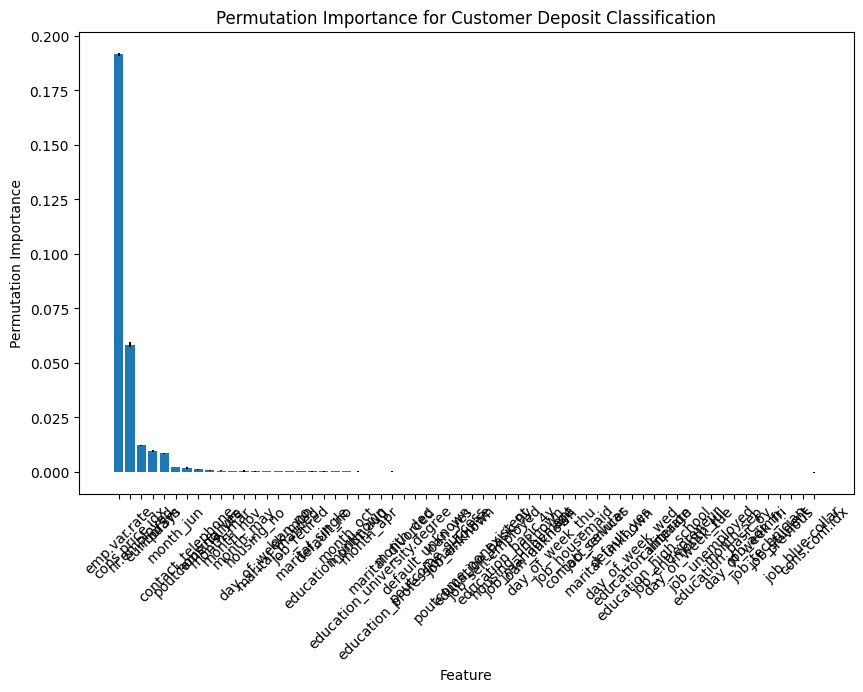

In [25]:
importance_df = pd.DataFrame({
    'feature': df_clean.drop(['y'], axis=1).columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std,
})
importance_df = importance_df.sort_values(by='importance_mean', ascending=False)
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(importance_df['feature'], importance_df['importance_mean'], yerr=importance_df['importance_std'])
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('Permutation Importance for Customer Deposit Classification')
plt.xticks(rotation=45)
plt.show()

This plot has way too much going on, so I'll subset it down to a more reasonable number of features.

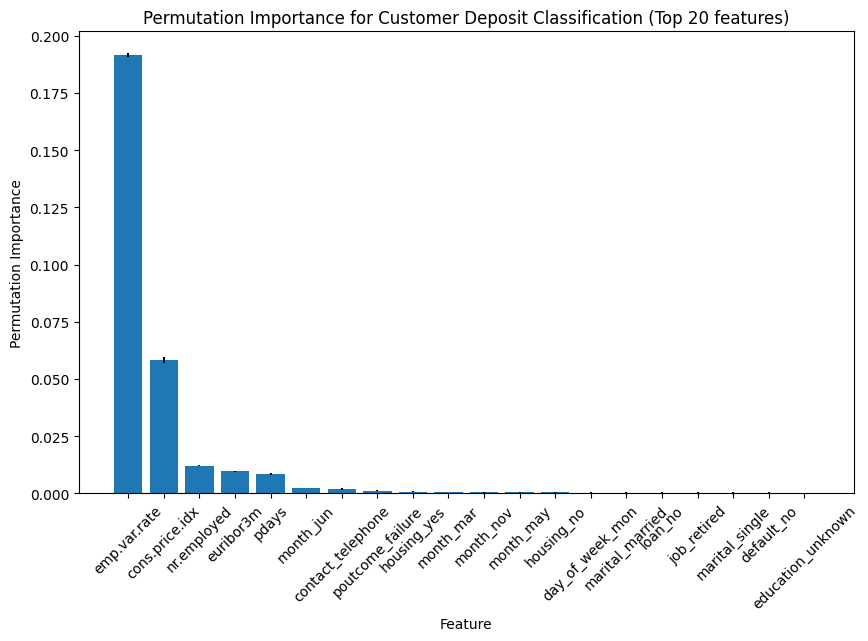

In [26]:
# Select down to the top 20 most important features
subset_importance_df = importance_df.head(20)
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(subset_importance_df['feature'], subset_importance_df['importance_mean'], yerr=subset_importance_df['importance_std'])
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('Permutation Importance for Customer Deposit Classification (Top 20 features)')
plt.xticks(rotation=45)
plt.show()

This provides an interesting look into what the logistic regression model places priority on.

#### Grid searching
I'll go through all four model types now and perform grid searches to see if we can optimize them further.

##### Logistic Regression

In [27]:
lr_params = {'C': [1.0, 2.0, 5.0, 10.0]}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=lr_params)

lr_grid.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [1.0, 2.0, 5.0, 10.0]})

In [28]:
lr_grid.best_params_

{'C': 5.0}

In [29]:
lr_grid.score(X_train, y_train)

0.9004196871423121

In [30]:
lr_grid.score(X_test, y_test)

0.9007849801731812

Not any improvement over the basic logistic regression model. I did also try using L1 regularization, but there were a lot of issues with model fitting, so I abandoned that.

In [31]:
lr_grid.predict(X_test[:5])

array(['no', 'no', 'no', 'no', 'no'], dtype=object)

In [32]:
# Define a fn to graph the ROC, so we can quickly graph this for different models
def generate_roc_graph(model, X, y):
  fpr, tpr, thresholds = roc_curve(np.where(y=='yes', 1, 0), np.where(model.predict(X)=='yes', 1, 0))
  roc_auc = auc(fpr, tpr)
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

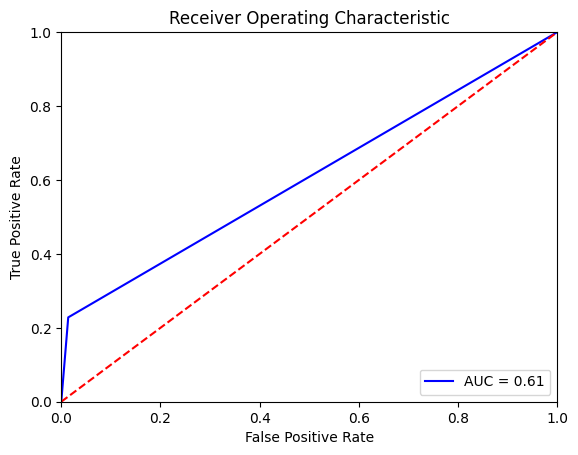

In [33]:
generate_roc_graph(lr_grid, X_test, y_test)

##### KNN

In [34]:
# Train a KNN classifier
knn_params = {'n_neighbors': list(range(5, 25, 5)), 'leaf_size': [10, 20, 30, 40, 50]}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid=knn_params)

knn_grid.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [10, 20, 30, 40, 50],
                         'n_neighbors': [5, 10, 15, 20]})

In [35]:
knn_grid.best_params_

{'leaf_size': 10, 'n_neighbors': 20}

In [36]:
knn_grid.score(X_train, y_train)

0.9023620408587978

In [37]:
knn_grid.score(X_test, y_test)

0.8974670227401473

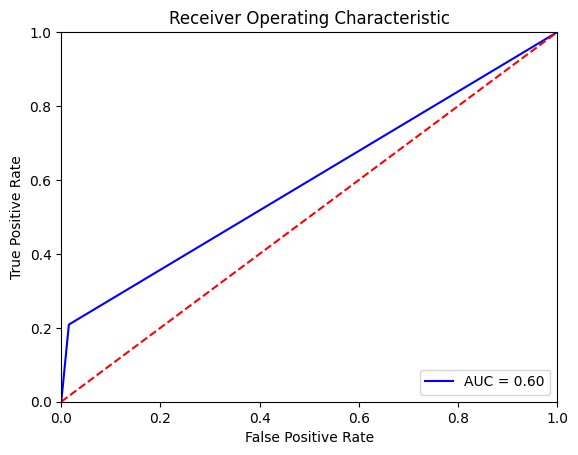

In [38]:
generate_roc_graph(knn_grid, X_test, y_test)

##### Decision Tree

I think there might be some room for improvement here, since the basic model appeared to be aggressively overfitting (99% training accuracy and only 84% test accuracy). Some regularization seems to be in order.

In [39]:
dt_params = {'max_depth': list(range(10, 50, 10)), 'min_samples_split': [2, 5, 10, 15], 'min_samples_leaf': [1, 5, 10, 15]}
dt_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=dt_params)

dt_grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [10, 20, 30, 40],
                         'min_samples_leaf': [1, 5, 10, 15],
                         'min_samples_split': [2, 5, 10, 15]})

In [40]:
dt_grid.best_params_

{'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 2}

In [41]:
dt_grid.score(X_train, y_train)

0.9091949637542922

In [42]:
dt_grid.score(X_test, y_test)

0.8985999838148417

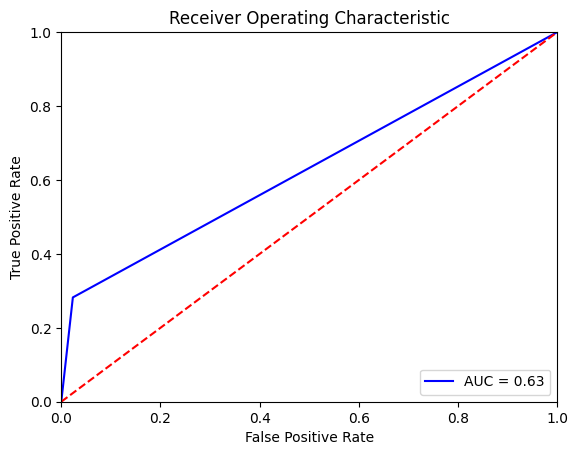

In [43]:
generate_roc_graph(dt_grid, X_test, y_test)

It looks like regularization did its job pretty well--now the performance is exactly in line with all the other classifiers. It's a shame, though, that we aren't able to improve much on the 89% test accuracy from the other models.

##### SVM

In [44]:
svm_params = {'C': [1.0, 2.0, 5.0, 10.0], 'degree': [2, 3]}
svm_grid = GridSearchCV(SVC(), param_grid=svm_params)

svm_grid.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1.0, 2.0, 5.0, 10.0], 'degree': [2, 3]})

In [45]:
svm_grid.score(X_train, y_train)

0.897818320557733

In [46]:
svm_grid.score(X_test, y_test)

0.8968196164117505

In [48]:
svm_grid.best_params_

{'C': 1.0, 'degree': 2}

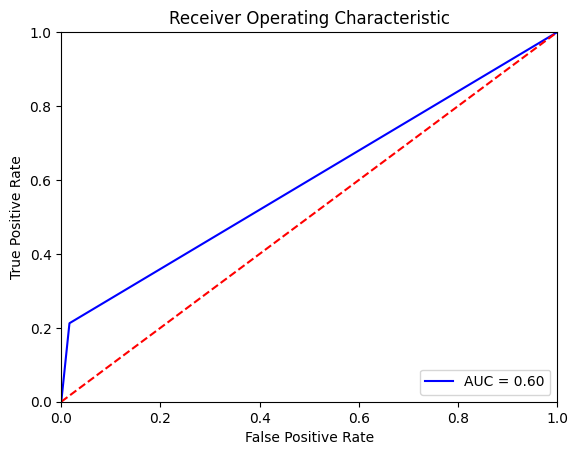

In [47]:
generate_roc_graph(svm_grid, X_test, y_test)

As a point of comparison, let's also take a look at the ROC graph for the baseline model (which used 'duration' as its only feature).

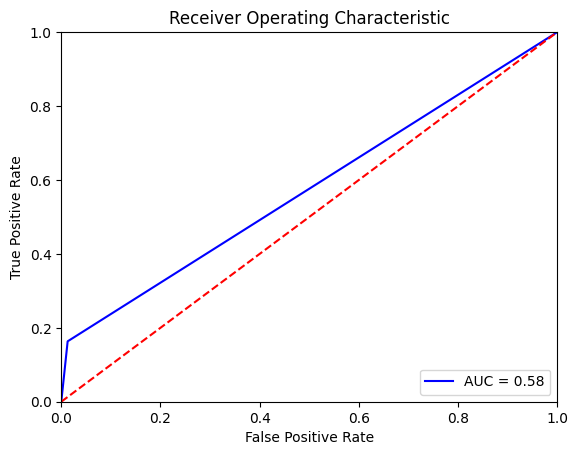

In [49]:
generate_roc_graph(lr_baseline, X_test_baseline, y_test_baseline)


##### Questions